##### Comparazione tra gradient boosting, random forest e vari modelli di reti neurali  
*Train set sul cromosoma 21, test sul cromosoma 22*

In [1]:
from fastai.tabular.all import *
from warnings import simplefilter
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
set_seed(42)
simplefilter(action="ignore", category=FutureWarning)

In [22]:
df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')
df = df.apply(lambda x: x.str.split(';') if x.dtype == "object" else x)
df = df.map(lambda x: x.remove('') if type(x) is list and '' in x else x)

l = []

for col in df.columns:
    if df[col].apply(lambda x: len(x) if type(x) is list else list()).equals(df['aapos'].apply(lambda x: len(x) if type(x) is list else list())):
        l.append(col)

l.append('TSL')
df = df.explode(l)
df = df.map(lambda x: x[0] if type(x) is list and len(x) == 1 else x)
df.replace(to_replace='.', value=np.nan, inplace=True)
df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
df.dropna(axis='columns', thresh=int(len(df.index)*0.8), inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')


l1 = []

for col in df.columns:
    if df[col].map(lambda x: True if type(x) is list else False).any():
        l1.append(col)

for col in l1:
    v = df[col].explode().value_counts()
    toRemove = v[v < int(len(df[col].explode()) * 0.10)].index
    df[col] = df[col].map(lambda x: [i for i in x if i not in toRemove] if type(x) is list else x)


dict = {}
for col in l1:
    v = df[col].explode().unique()
    dict[col] = {"Valori unici": len(v), "Esempi": v[0:10]}

df_ex = pd.DataFrame.from_dict(dict, orient='index')
df_ex.columns = ['Valori unici', 'Esempi']
print(df_ex)

def check_empty(x):
    for i in x:
        if i != ' ' and type(i) != float:
            return False
    return True

for key, value in dict.items():
    if value['Valori unici'] > 10 or check_empty(value['Esempi']) or value['Valori unici'] == 1:
        df.drop(key, axis=1, inplace=True)
    else:
        v = sorted(df[key].explode().replace(to_replace=np.nan, value= 'NaT').unique())
        for c in v:
            if c == 'NaT':
                continue
            df[c] = df[key].replace(to_replace=np.nan, value= 'NaT').apply(lambda lis: int(c in lis))
        df.drop(key, axis=1, inplace=True)

/tmp/ipykernel_39344/2574161820.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')


                           Valori unici  \
MutationTaster_score                509   
MutationTaster_pred                   5   
MutationTaster_model                  4   
MutationTaster_AAE                 1377   
CCDS_id                              53   
Refseq_id                            75   
Pathway(ConsensusPathDB)              8   
Function_description                  2   
Disease_description                   2   
Orphanet_disorder_id                 21   
Orphanet_disorder                    21   
Orphanet_association_type             5   
HPO_id                                1   
HPO_name                              1   
GO_biological_process                 6   
GO_cellular_component                 5   
GO_molecular_function                 8   
MGI_mouse_phenotype                   1   

                                                                                                                                                                                      

In [23]:
df.apply(pd.to_numeric, errors='ignore')
df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'not_provided'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'protective'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df.replace(to_replace='Benign/Likely_benign', value='Benign', inplace=True)
df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Pathogenic', inplace=True)
df.replace(to_replace=np.nan, value=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [24]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
df_data = df.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df = df.sample(frac=1).reset_index(drop=True)

In [25]:
to = TabularPandas(df, procs=[Categorify, FillMissing],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [26]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [27]:
dls = to.dataloaders(bs=1024)

*Gradient boosting*

In [ ]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

In [ ]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.best_params_)

In [28]:
gb = GradientBoostingClassifier()

In [29]:
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [31]:
p = gb.predict(X_test)

In [32]:
print(accuracy_score(y_test, p))

0.9345857094934585


*Random forest*

In [33]:
rfc=RandomForestClassifier(random_state=42)

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

In [34]:
rfc1=RandomForestClassifier(random_state=42, max_features='log2', max_depth=30, criterion='gini', min_samples_leaf=1)

In [35]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, max_features='log2', random_state=42)

In [36]:
pred=rfc1.predict(X_test)

In [37]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.9795370680979537


In [38]:
test_df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')
test_df = test_df.apply(lambda x: x.str.split(';') if x.dtype == "object" else x)
test_df = test_df.map(lambda x: x.remove('') if type(x) is list and '' in x else x)

l = []

for col in test_df.columns:
    if test_df[col].apply(lambda x: len(x) if type(x) is list else list()).equals(test_df['aapos'].apply(lambda x: len(x) if type(x) is list else list())):
        l.append(col)

l.append('TSL')
test_df = test_df.explode(l)
test_df = test_df.map(lambda x: x[0] if type(x) is list and len(x) == 1 else x)
test_df.replace(to_replace='.', value=np.nan, inplace=True)
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.dropna(axis='columns', thresh=int(len(test_df.index)*0.8), inplace=True)
test_df = test_df.apply(pd.to_numeric, errors='ignore')


l1 = []

for col in test_df.columns:
    if test_df[col].map(lambda x: True if type(x) is list else False).any():
        l1.append(col)

for col in l1:
    v = test_df[col].explode().value_counts()
    toRemove = v[v < int(len(test_df[col].explode()) * 0.10)].index
    test_df[col] = test_df[col].map(lambda x: [i for i in x if i not in toRemove] if type(x) is list else x)


dict = {}
for col in l1:
    v = test_df[col].explode().unique()
    dict[col] = {"Valori unici": len(v), "Esempi": v[0:10]}

for key, value in dict.items():
    if value['Valori unici'] > 10 or check_empty(value['Esempi']) or value['Valori unici'] == 1:
        test_df.drop(key, axis=1, inplace=True)
    else:
        v = sorted(test_df[key].explode().replace(to_replace=np.nan, value= 'NaT').unique())
        for c in v:
            if c == 'NaT':
                continue
            test_df[c] = test_df[key].replace(to_replace=np.nan, value= 'NaT').apply(lambda lis: int(c in lis))
        test_df.drop(key, axis=1, inplace=True)

/tmp/ipykernel_39344/232733172.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')


In [39]:
cols = [col for col in df.columns if col not in test_df.columns]
for col in cols:
    test_df[col] = 0

cols = [col for col in df.columns if col in test_df.columns]
test_df = test_df[cols]

test_df.apply(pd.to_numeric, errors='ignore')
test_df.replace(to_replace=np.nan, value=0, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'not_provided'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'protective'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'drug_response'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'association'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Affects'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'other'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'drug_response,_risk_factor'].index, inplace=True)
test_df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Likely_benign,_other', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Likely_benign,_drug_response,_other', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign,_other', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign,_risk_factor', value='Likely_pathogenic', inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [40]:
to_test = TabularPandas(test_df, procs=[Categorify, FillMissing], cat_names = cat_cols, cont_names = num_cols, y_names='clinvar_clnsig', y_block=CategoryBlock())

In [41]:
X_test = to_test.train.xs
y_test = to_test.train.ys.values.ravel()

p = gb.predict(X_test)

print(accuracy_score(y_test, p))

pred=rfc1.predict(X_test)

print("Accuracy for Random Forest on test data: ",accuracy_score(y_test,pred))


0.7684380202415242
Accuracy for Random Forest on test data:  0.8504082657294612


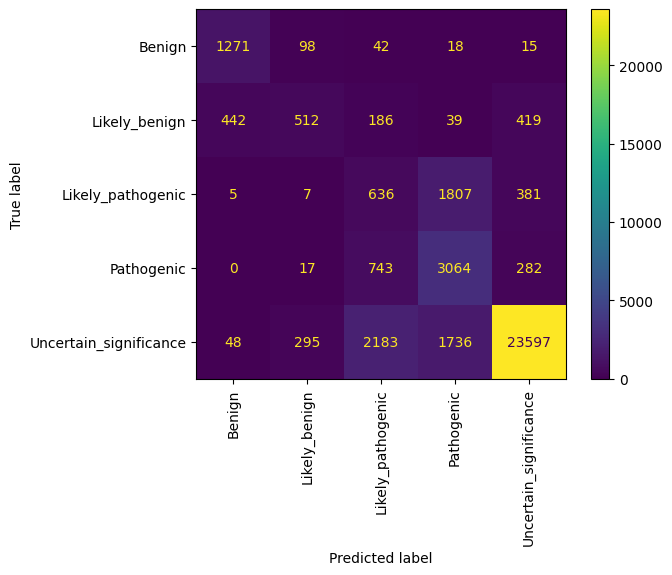

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')

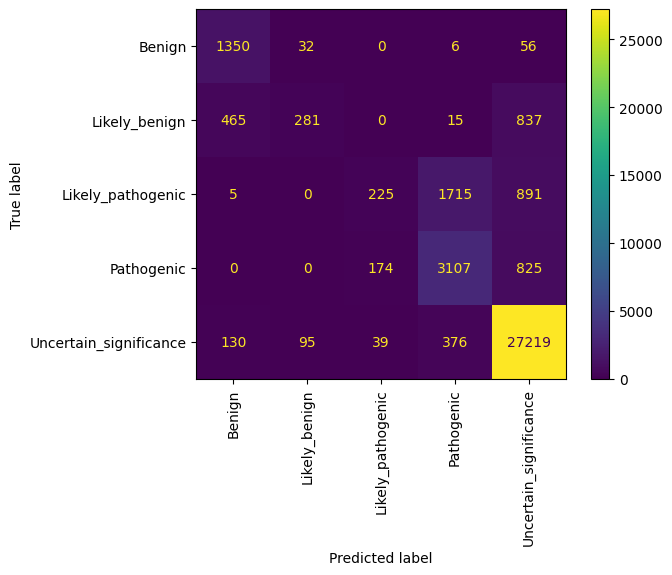

In [43]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')

*Restrizione delle features*

,MetaRNN_score,MetaRNN_rankscore,M-CAP_score,clinvar_review,clinvar_id,M-CAP_rankscore,FATHMM_converted_rankscore,M-CAP_pred,MPC_rankscore,ClinPred_score,...,DANN_score,rs_dbSNP,MutationTaster_converted_rankscore,phyloP100way_vertebrate,MetaLR_rankscore,aapos,CADD_raw_hg19,MetaSVM_pred,fathmm-MKL_coding_rankscore,HGVSp_VEP
0,0.032912,0.01453,0.053644,"criteria_provided,_conflicting_interpretations",393153,0.65550,0.78199,D,0.27591,0.078024,...,0.883857,rs374097903,0.49770,5.891,0.71265,99,2.052285,T,0.81092,p.Val99Ala
1,0.702740,0.72546,0.025662,"criteria_provided,_single_submitter",916062,0.48617,0.18570,D,0.97346,0.986964,...,0.998978,0,0.81001,5.119,0.40559,395,3.919253,T,0.68826,p.Phe395Leu
2,0.978606,0.97745,0.654978,"criteria_provided,_single_submitter",46100,0.97089,0.95282,D,0.41879,0.962601,...,0.997644,rs397517371,0.45389,1.621,0.97726,400,3.678245,D,0.51922,p.Asp400Glu
3,0.674634,0.70917,0.053826,"criteria_provided,_single_submitter",478367,0.65620,0.58468,D,0.91459,0.974837,...,0.999442,rs547450707,0.81001,6.370,0.76816,270,4.776440,T,0.49177,p.Arg270Cys
4,0.031962,0.01339,0.056272,"criteria_provided,_single_submitter",953747,0.66544,0.97394,D,0.38103,0.027868,...,0.610562,rs770505759,0.08975,-0.371,0.90930,215,0.099751,T,0.17782,p.Asn215Asp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14902,0.238937,0.41024,0.410413,"criteria_provided,_single_submitter",581637,0.93586,0.90962,D,0.31777,0.428675,...,0.998447,rs369764291,0.08975,0.551,0.85294,1012,2.527744,T,0.10146,p.Arg1012His
14903,0.247547,0.42037,0.165929,"criteria_provided,_single_submitter",965496,0.84467,0.77719,D,0.15033,0.242177,...,0.784691,0,0.41587,0.154,0.68960,20,2.247299,T,0.29177,p.Ala20Thr
14904,0.008764,0.00198,0.023733,"criteria_provided,_multiple_submitters,_no_conflicts",478345,0.46702,0.93882,T,0.15689,0.008102,...,0.971283,rs145937537,0.28659,0.866,0.89246,1150,-0.073229,T,0.24525,p.Thr1150Met
14905,0.621098,0.67982,0.055878,"criteria_provided,_single_submitter",835975,0.66396,0.64264,D,0.86800,0.567921,...,0.999573,rs757789128,0.81001,10.003,0.52721,205,3.613172,T,0.90771,p.Arg205Gln


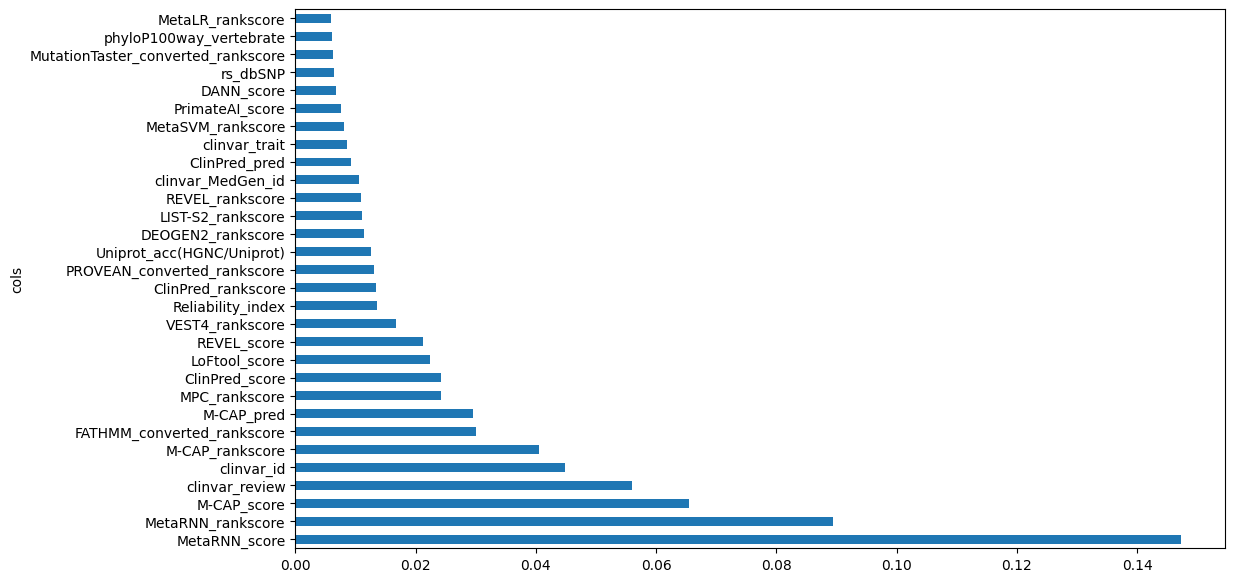

In [44]:
def rf(xs, y, n_estimators=40, max_samples=3328,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

xs,y = to.train.xs,to.train.y
m = rf(xs, y)

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

to_keep = fi[fi.imp>0.005].cols

df_keep = df[to_keep].copy()
df_keep

In [45]:
num_cols = df_keep.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_keep.select_dtypes(include=[object]).columns.tolist()
df = pd.concat([df['clinvar_clnsig'], df_keep], axis=1)
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))

In [46]:
to = TabularPandas(df, procs=[Categorify, FillMissing],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [47]:
dls = to.dataloaders(bs=1024)

In [48]:
cols = [col for col in df.columns if col not in test_df.columns]
for col in cols:
    test_df[col] = 0

cols = [col for col in df.columns if col in test_df.columns]
test_df = test_df[cols]

test_df.apply(pd.to_numeric, errors='ignore')
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'not_provided'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'protective'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
test_df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign', value='Benign', inplace=True)
test_df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Pathogenic', inplace=True)
test_df.replace(to_replace=np.nan, value=0, inplace=True)
test_df.reset_index(drop=True, inplace=True)
#test_dl = dls.test_dl(test_df)

*Tabular learner con loss function di raggruppamento*

In [49]:
classes = {0: 1, 1: 1, 2: 2, 3: 2, 4: 3}

class GroupLoss(nn.Module):
    def __init__(self, gamma = 2.0):
        super(GroupLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inp, targ):
        sm_acts = torch.softmax(inp, dim=1)
        losses = []
        for i in range(len(targ)):
            target_class = classes[targ[i].item()]
            pred_class = sm_acts[i].argmax().item()
            if target_class != classes[pred_class]:
                losses.append(torch.pow(1 - sm_acts[i][targ[i].item()], self.gamma) * torch.log(sm_acts[i][targ[i].item()]) * 3)
            else:
                losses.append(torch.pow(1 - sm_acts[i][targ[i].item()], self.gamma) * torch.log(sm_acts[i][targ[i].item()]))
      
        return -torch.stack(losses).mean()

In [50]:
def accuracy_pen(input, target):
    sm_acts = torch.softmax(input, dim=1),
    preds = sm_acts.argmax(dim=1),
    preds_class = [classes[pred.item()] for pred in preds],
    targ_class = [classes[t.item()] for t in target],
    return (torch.tensor(preds_class) == torch.tensor(targ_class)).float().mean()

In [51]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=GroupLoss(gamma=6))

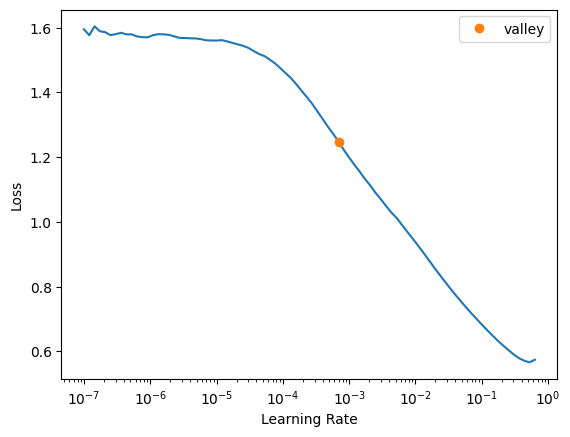

In [52]:
torch.cuda.empty_cache()
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.643849,1.168079,0.083194,00:01
1,0.468917,1.058641,0.083194,00:01
2,0.361093,0.646598,0.397182,00:01
3,0.267158,0.215585,0.826233,00:01
4,0.195557,0.082176,0.929218,00:01
5,0.145429,0.053423,0.949346,00:01
6,0.109989,0.047875,0.958068,00:01
7,0.084335,0.046448,0.960081,00:01
8,0.065391,0.046136,0.959074,00:01
9,0.051157,0.048060,0.958739,00:01


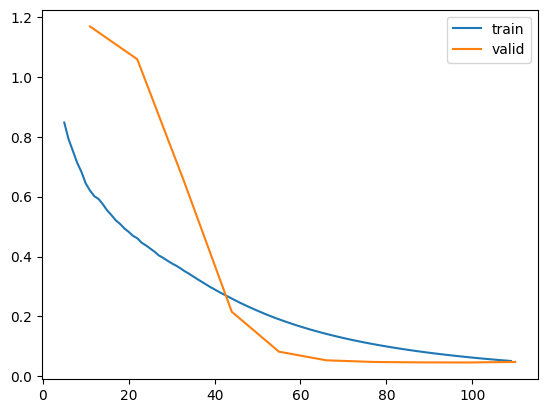

In [53]:
learn.fit(10, lr, 1e-3)
learn.recorder.plot_loss()

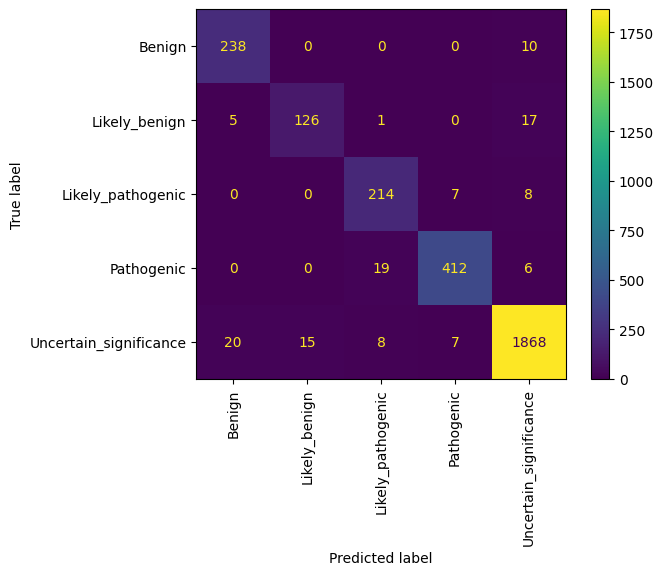

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds, targets = learn.get_preds(ds_idx=1)
pred_classes = np.argmax(preds, axis=1)

# Flattening delle etichette di classe
true_classes = targets.squeeze().numpy()

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')

In [55]:
test_dl = dls.test_dl(test_df)
learn.validate(dl=test_dl)

(#2) [0.43279317021369934,0.7134476900100708]

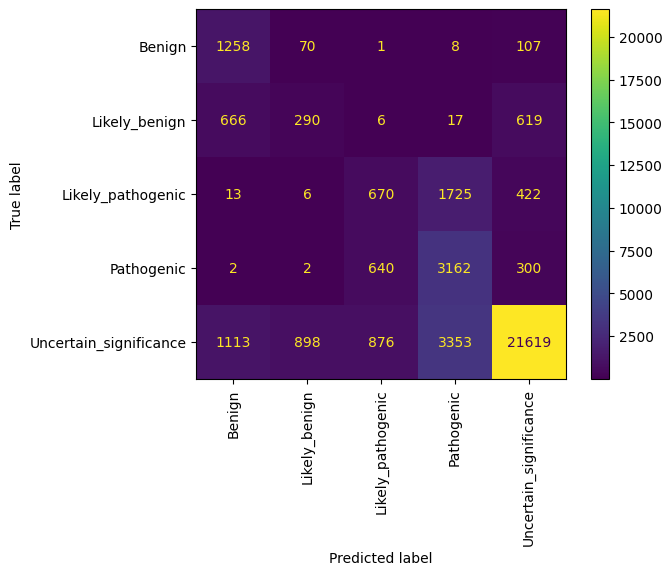

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds, targets = learn.get_preds(dl=test_dl)
pred_classes = np.argmax(preds, axis=1)

# Flattening delle etichette di classe
true_classes = targets.squeeze().numpy()

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')

*Tabular learner standard*

In [60]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=FocalLossFlat(gamma=7))

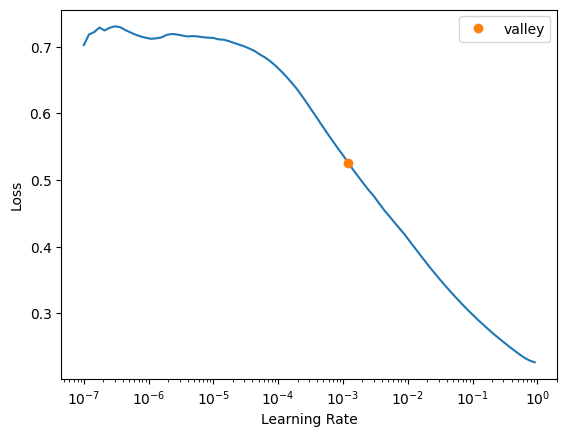

In [61]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.231721,0.243068,0.665213,00:00
1,0.157516,0.159873,0.774237,00:00
2,0.107416,0.081048,0.904730,00:00
3,0.073781,0.029580,0.947669,00:00
4,0.052671,0.016992,0.956055,00:00
5,0.038737,0.015094,0.956055,00:00
6,0.029129,0.015043,0.957397,00:00
7,0.022262,0.015084,0.960416,00:00
8,0.017222,0.015352,0.960751,00:00
9,0.013441,0.015490,0.960751,00:00


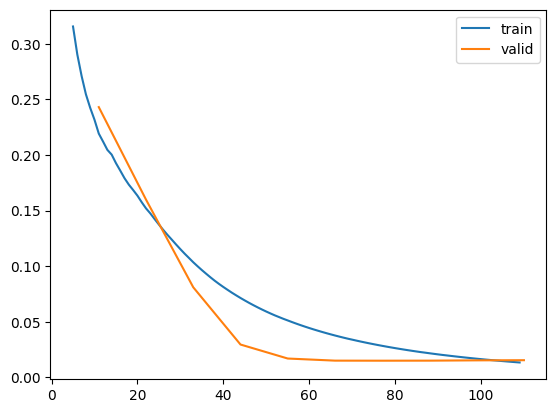

In [62]:
learn.fit(10, lr, wd=0.01)
learn.recorder.plot_loss()

In [63]:
test_dl = dls.test_dl(test_df)
learn.validate(dl=test_dl)

(#2) [0.1372598260641098,0.7378379106521606]

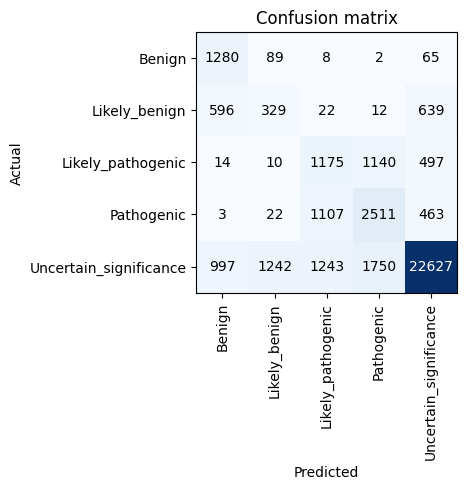

In [64]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_confusion_matrix()